In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hvplot.pandas
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize

In [7]:
data = pd.read_csv('dataset.csv', sep=';')

# Mapping de la columna Target
status_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
data['Target'] = data['Target'].map(status_mapping)

# Definición de variables a analizar
y = data['Target']
X = data.drop(columns=['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del modelo base
model = DecisionTreeClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

# Búsqueda exhaustiva con GridSearch
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor precisión:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mejor precisión: 0.7544482535420612

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.65      0.75       316
           1       0.72      0.95      0.82       418
           2       0.46      0.31      0.37       151

    accuracy                           0.74       885
   macro avg       0.69      0.64      0.65       885
weighted avg       0.74      0.74      0.72       885



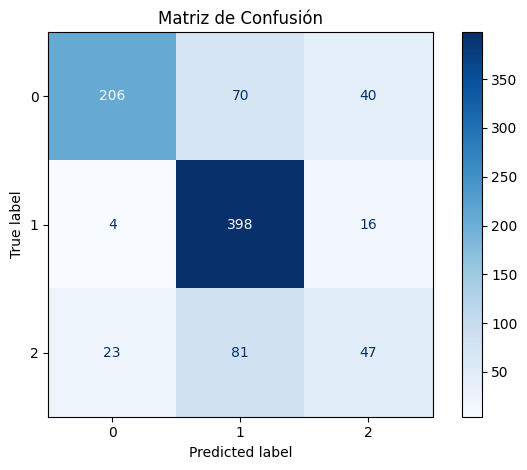

In [13]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig('mat_dt.pdf')
plt.show()

In [9]:
# Evalucación de desempeño
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Puntuación en el conjunto de entrenamiento: {train_score:.2f}")
print(f"Puntuación en el conjunto de prueba: {test_score:.2f}")

if train_score > test_score + 0.1:
    print("El modelo podría estar sobreajustado (overfitting).")
elif test_score > train_score + 0.1:
    print("El modelo podría estar subajustado (underfitting).")
else:
    print("El modelo parece estar bien ajustado.")

Puntuación en el conjunto de entrenamiento: 0.77
Puntuación en el conjunto de prueba: 0.74
El modelo parece estar bien ajustado.


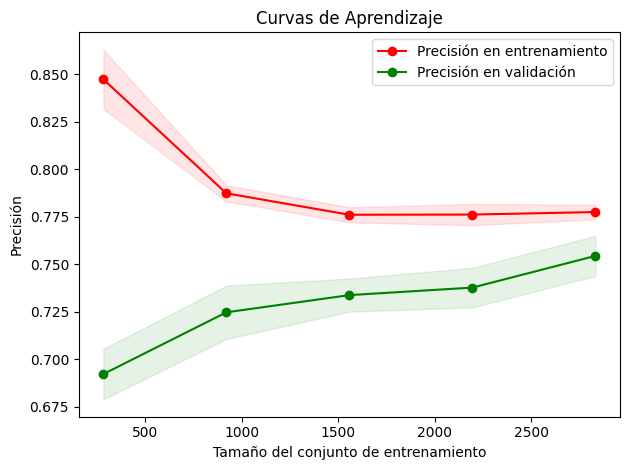

In [15]:
# Curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Precisión en entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Precisión en validación")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.title("Curvas de Aprendizaje")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('aprend_dt.pdf')
plt.show()

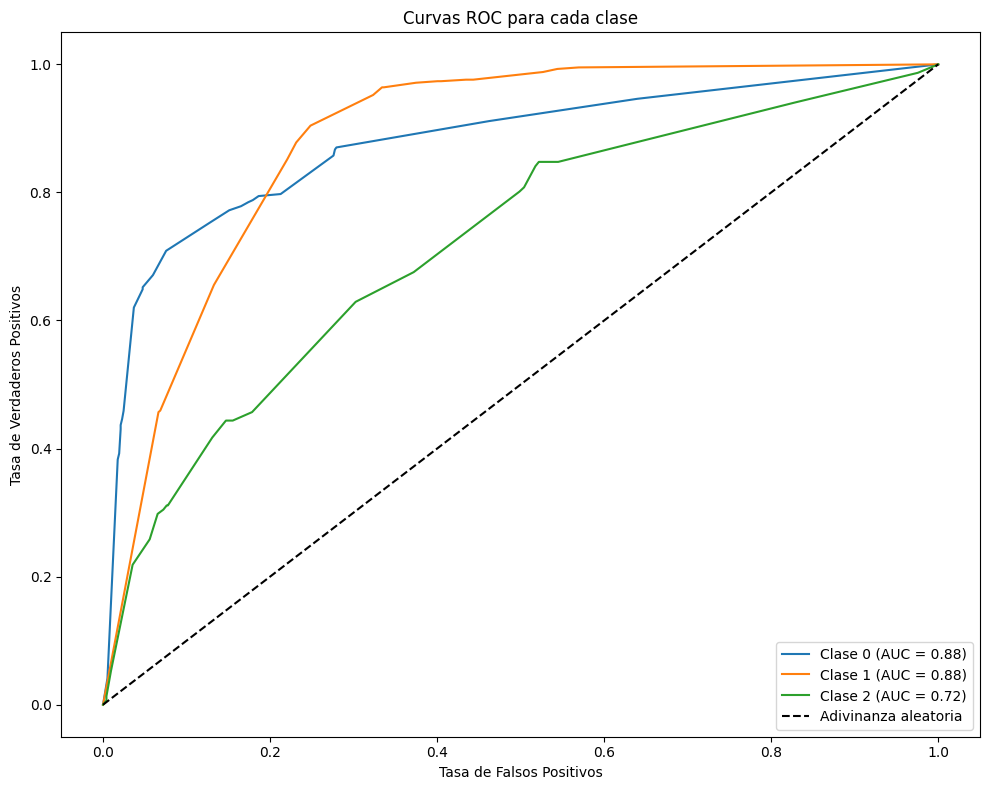

In [16]:
# Curvas ROC
y_prob = best_model.predict_proba(X_test)
n_classes = len(best_model.classes_)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test == i, y_prob[:, i])  # "i" es la clase positiva
    auc_score = roc_auc_score(y_test == i, y_prob[:, i])  # AUC de la clase

    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Adivinanza aleatoria")

plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC para cada clase")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC_dt.pdf')
plt.show()